# Charactérisation de l'espace des phases pour extraction lente

Dans cet exemple nous nous intéresserons à l'espace des phases lors de l'excitation d'une résonance du troisième ordre pour l'extraction lente.
Nous déterminerons sa topologie, les régions stables et instables, la séparatrice ainsi que sa pente à l'endroit du septum.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xtrack as xt
from helpers import arrange_phase_space_plot

%config InlineBackend.figure_format = "retina"

## Chargement de la maille PIMMS

In [2]:
env = xt.load("inputs/pimms.json")
ring = env.pimms

Loading line from dict:   0%|          | 0/111 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
# Alimentation des sextupoles d'extraction
env["kse1"] = 1
env["kse2"] = -6.5

## Topologie de l'espace des phases avec excitation de la résonance

In [4]:
# Génération de 20 particules sur l'axe horizontal
x_gen = np.linspace(0, 2.5e-2, 25)
parts = ring.build_particles(x=x_gen, px=0, y=0, py=0, zeta=0, delta=0)

# Tracking des particules pour 1000 tours
ring.track(parts, num_turns=1000, turn_by_turn_monitor=True)
record = ring.record_last_track

In [5]:
%%capture
# Il est possible d'obtenir facilement les coordonnées normalisées
twiss = ring.twiss4d()
norm_coords = twiss.get_normalized_coordinates(record)

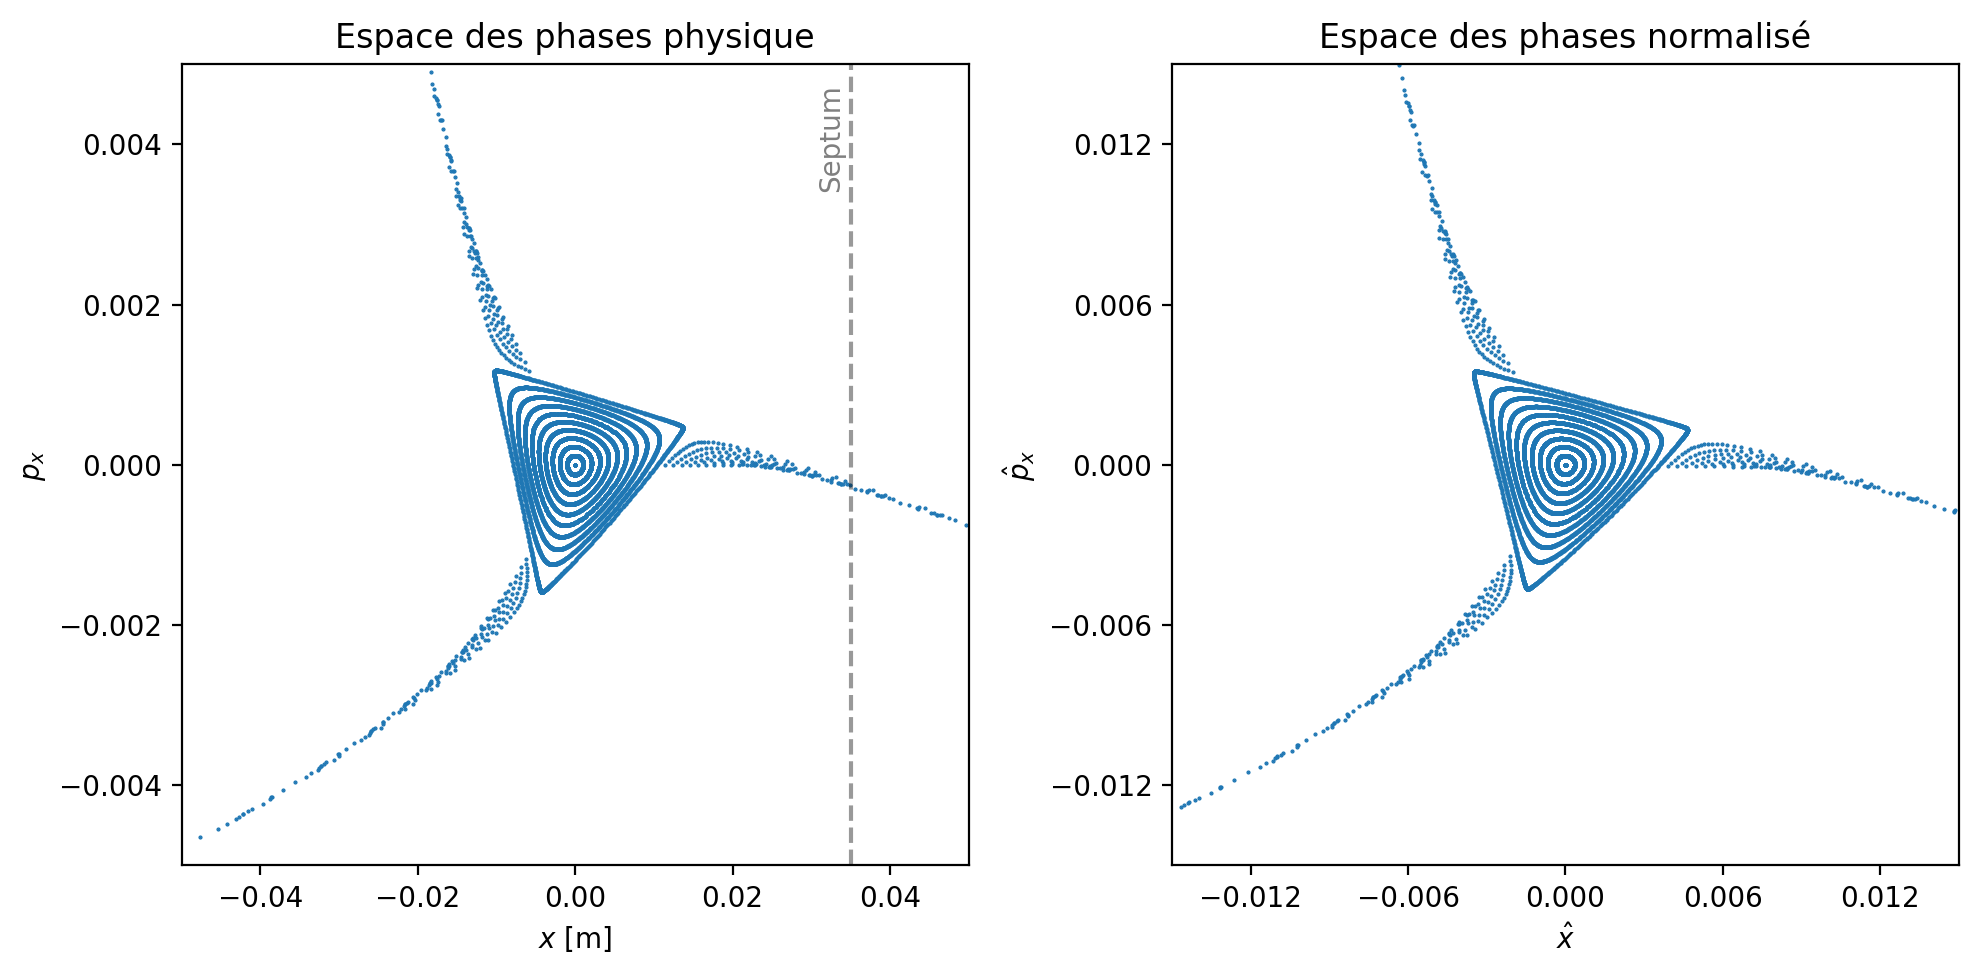

In [6]:
# Visualisons les deux espaces des phases côte-à-côte
fig, ax_geom, ax_norm = arrange_phase_space_plot()
x_septum = 3.5e-2
ymin, ymax = ax_geom.get_ylim()
ax_geom.plot(record.x.T, record.px.T, ".", markersize=1, color="C0")
ax_norm.plot(norm_coords.x_norm.T, norm_coords.px_norm.T, ".", markersize=1, color="C0")
ax_geom.axvline(x=x_septum, color="k", alpha=0.4, linestyle="--")
ax_geom.text(x_septum * 0.98, ymax * 0.95, "Septum", rotation=90, va="top", ha="right", alpha=0.5, c="k")
plt.tight_layout()

## Identification de la séparatrice

Une boucle logique de recherche binaire permet de localiser la transition entre les régions de motion stable et instable.

In [7]:
# Région de recherche de la séparatrice
search_region = [0, 0.03]
num_turns = 1000

In [8]:
# Recherche binaire via tracking
while search_region[1] - search_region[0] > 1e-6:
    # Génération d'une particule au centre de la région
    x_test = (search_region[0] + search_region[1]) / 2
    p = ring.build_particles(x=x_test, px=0)

    # Tracking de la particule
    ring.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
    rec_test = ring.record_last_track

    # Mise à jour de la région de recherche
    if (rec_test.x > x_septum).any():
        # La particle test est instable
        # => Séparatrice à droite de x_test
        search_region[1] = x_test
    else:
        # La particle test est stable
        # => Séparatrice à gauche de x_test
        search_region[0] = x_test

# On peut voir les limites de la région
print(search_region)

[0.0104351806640625, 0.01043609619140625]


In [9]:
%%capture
# On track une particule juste au-delà des limites de cette région
p = ring.build_particles(x=search_region[1])
ring.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
rec_separatrice = ring.record_last_track
norm_separatrice = twiss.get_normalized_coordinates(rec_separatrice)  # coordonnées normalisées

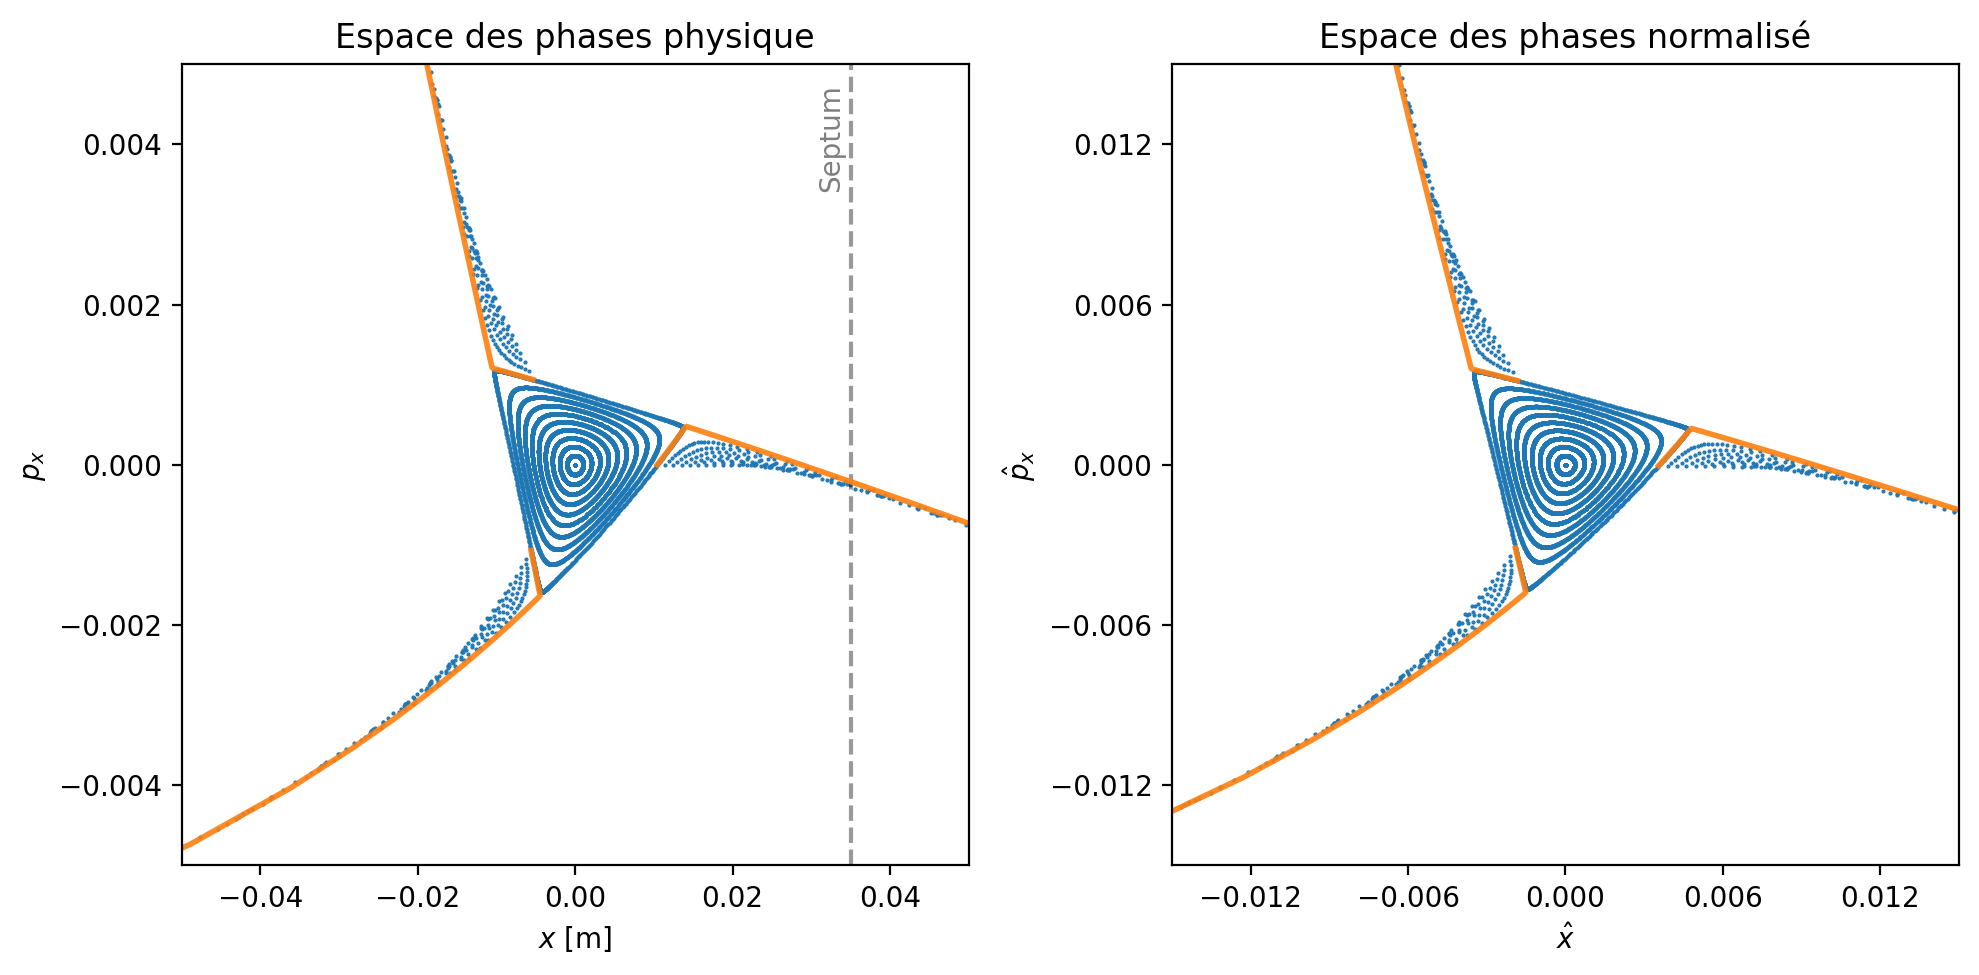

In [10]:
# On peut rajouter la séparatrice à la topologie de l'espace des phases
fig, ax_geom, ax_norm = arrange_phase_space_plot()
ymin, ymax = ax_geom.get_ylim()
ax_geom.plot(record.x.T, record.px.T, ".", markersize=1, color="C0")
ax_norm.plot(norm_coords.x_norm.T, norm_coords.px_norm.T, ".", markersize=1, color="C0")
ax_geom.axvline(x=x_septum, color="k", alpha=0.4, linestyle="--")
ax_geom.text(x_septum * 0.98, ymax * 0.95, "Septum", rotation=90, va="top", ha="right", alpha=0.5, c="k")

# Rajout de la séparatrice identifiée
mask_alive = rec_separatrice.state > 0
for ii in range(3):
    ax_geom.plot(
        rec_separatrice.x[mask_alive][ii::3],
        rec_separatrice.px[mask_alive][ii::3],
        "-",
        lw=2,
        color="C1",
        alpha=0.9,
    )
    ax_norm.plot(
        norm_separatrice.x_norm[mask_alive][ii::3],
        norm_separatrice.px_norm[mask_alive][ii::3],
        "-",
        lw=2,
        color="C1",
        alpha=0.9,
    )

plt.tight_layout()

## Mesure de la pente de la séparatrice au septum

In [11]:
# Coordonnées de la séparatrice identifiée
x_separ = rec_separatrice.x[0, :]
px_separ = rec_separatrice.px[0, :]

In [12]:
# Identifions le tour auquel la particule était le plus proche du septum
i_septum = np.argmin(np.abs(x_separ - x_septum))

# Ajustons la ligne en prenant le passage précédent et le suivant. Il faut 3 tours pour
# que la particule retourne sur cette branche, d'où l'offset de 3
poly_sep = np.polyfit(
    [x_separ[i_septum + 3], x_separ[i_septum - 3]],
    [px_separ[i_septum + 3], px_separ[i_septum - 3]],
    deg=1,
)
dpx_dx_at_septum = poly_sep[0]
print("dpx_dx_at_septum = ", dpx_dx_at_septum)

dpx_dx_at_septum =  -0.034284051667792956


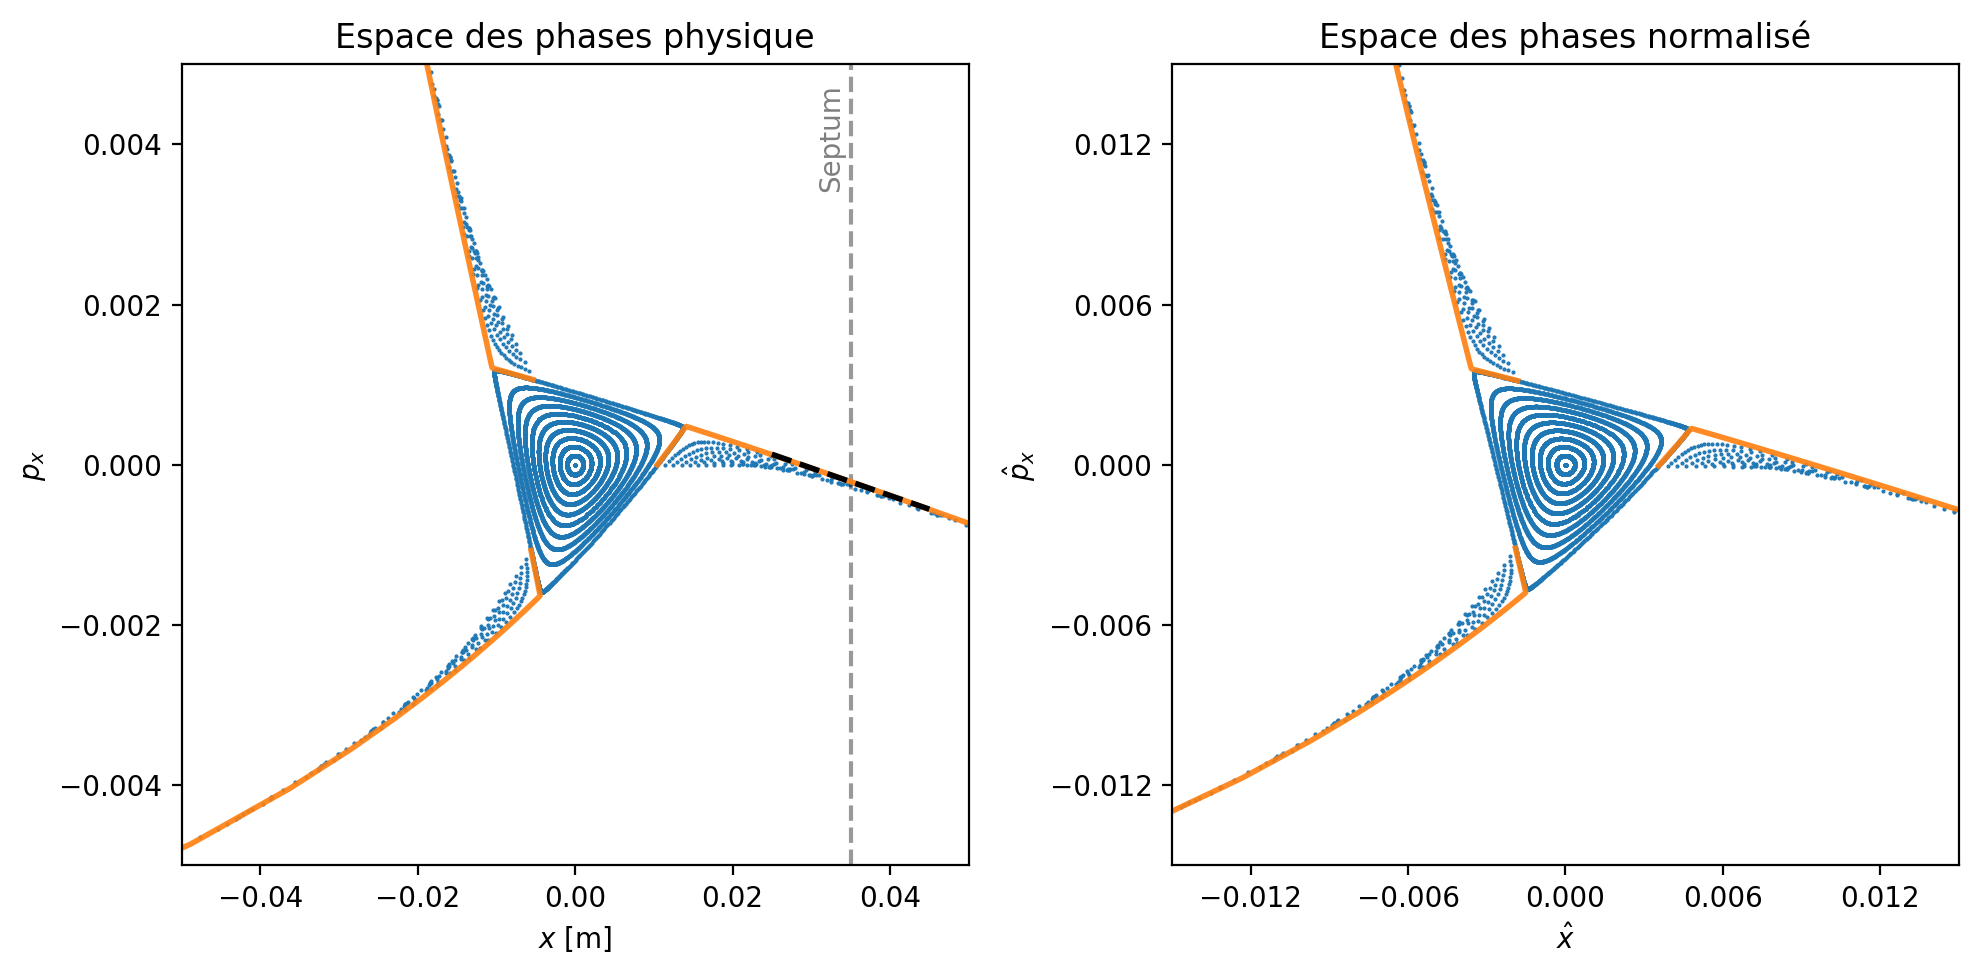

In [13]:
# On peut rajouter la pente à la topologie de l'espace des phases
fig, ax_geom, ax_norm = arrange_phase_space_plot()
ymin, ymax = ax_geom.get_ylim()
ax_geom.plot(record.x.T, record.px.T, ".", markersize=1, color="C0")
ax_norm.plot(norm_coords.x_norm.T, norm_coords.px_norm.T, ".", markersize=1, color="C0")
ax_geom.axvline(x=x_septum, color="k", alpha=0.4, linestyle="--")
ax_geom.text(x_septum * 0.98, ymax * 0.95, "Septum", rotation=90, va="top", ha="right", alpha=0.5, c="k")

# Rajout de la séparatrice identifiée
mask_alive = rec_separatrice.state > 0
for ii in range(3):
    ax_geom.plot(
        rec_separatrice.x[mask_alive][ii::3],
        rec_separatrice.px[mask_alive][ii::3],
        "-",
        lw=2,
        color="C1",
        alpha=0.9,
    )
    ax_norm.plot(
        norm_separatrice.x_norm[mask_alive][ii::3],
        norm_separatrice.px_norm[mask_alive][ii::3],
        "-",
        lw=2,
        color="C1",
        alpha=0.9,
    )

# Rajout de la pente de la séparatrice au septum
intervale_x_pente = [x_septum - 1e-2, x_septum + 1e-2]
ax_geom.plot(intervale_x_pente, np.polyval(poly_sep, intervale_x_pente), "--k", linewidth=2)

plt.tight_layout()

## Identification de la zone stable

In [14]:
# On track une particule juste en-deçà des limites de cette région
p = ring.build_particles(x=search_region[0])
ring.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
rec_triangle = ring.record_last_track
nc_triangle = twiss.get_normalized_coordinates(rec_triangle)  # coordonnées normalisées

x_triangle = rec_triangle.x[0, :]
px_triangle = rec_triangle.px[0, :]
x_norm_triangle = nc_triangle.x_norm[0, :]
px_norm_triangle = nc_triangle.px_norm[0, :]

In [15]:
# Trions les coordonnées de la frontière par theta croissant
theta_triangle = np.angle(x_norm_triangle + 1j * px_norm_triangle)
i_sorted = np.argsort(theta_triangle)

x_triangle = x_triangle[i_sorted]
px_triangle = px_triangle[i_sorted]
x_norm_triangle = x_norm_triangle[i_sorted]
px_norm_triangle = px_norm_triangle[i_sorted]

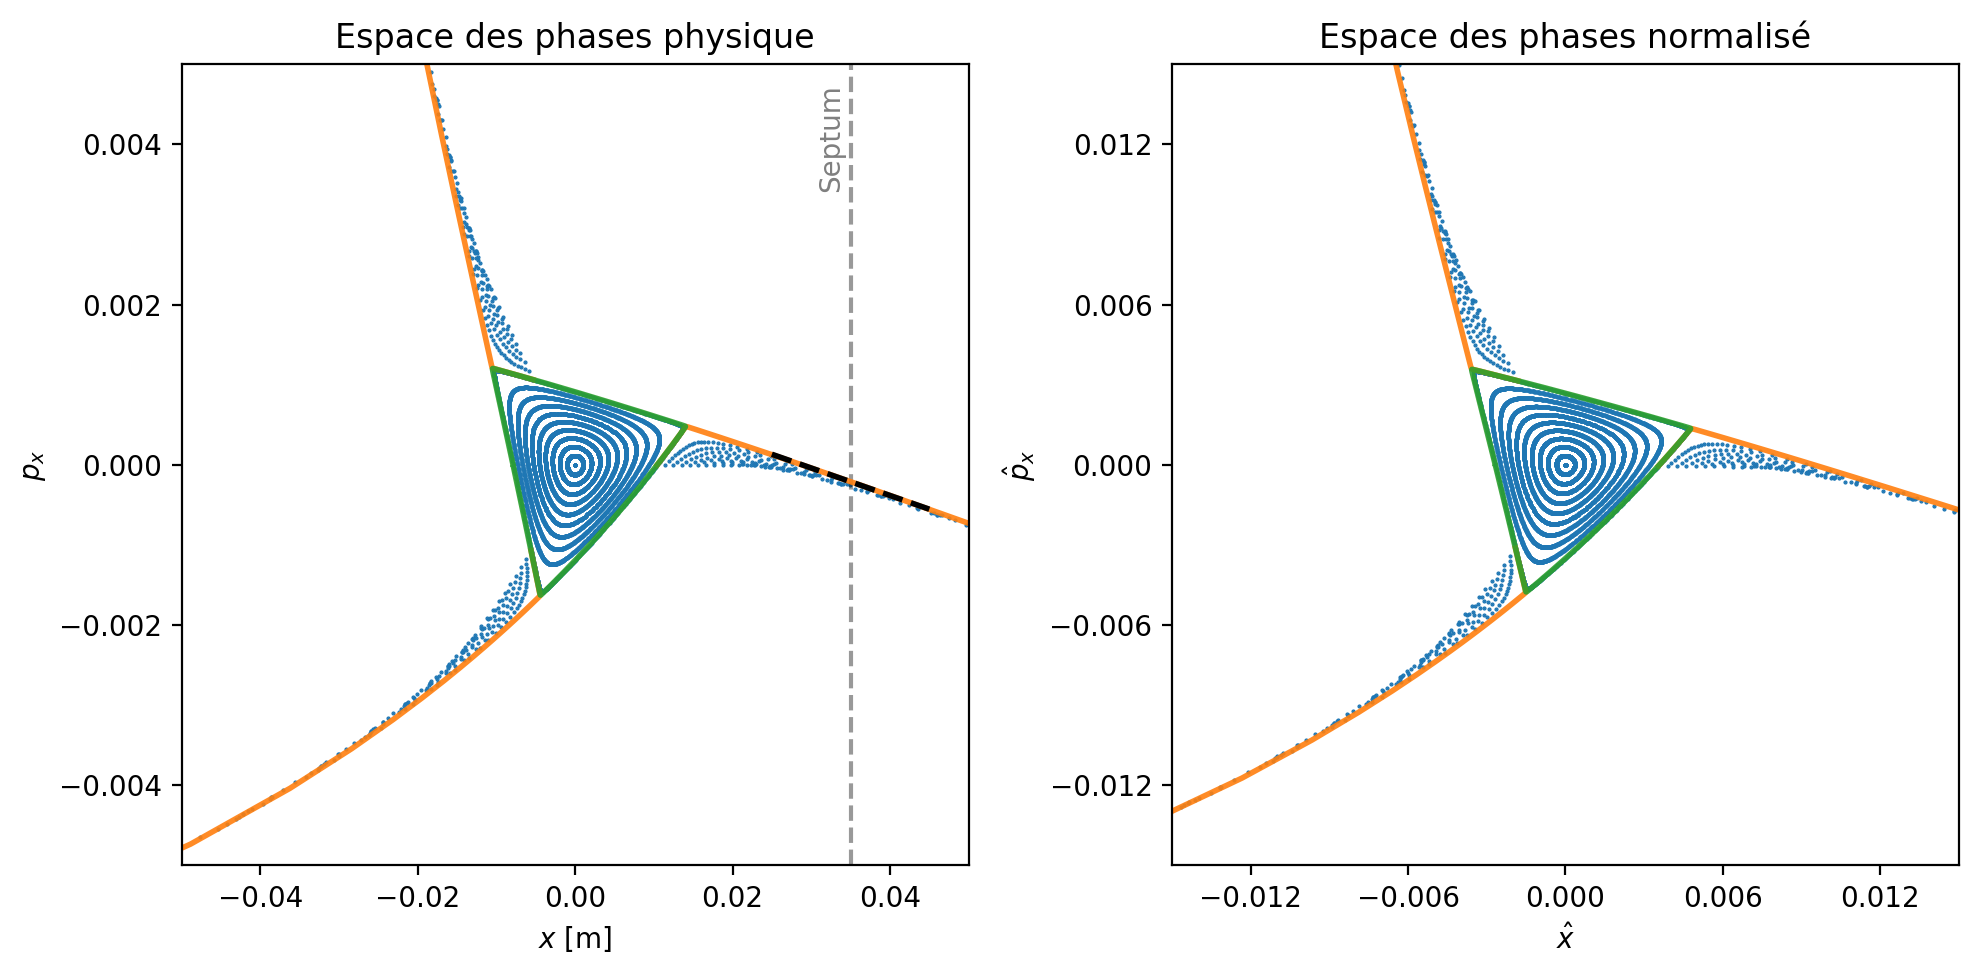

In [16]:
# On peut rajouter la zone stable à la topologie de l'espace des phases
fig, ax_geom, ax_norm = arrange_phase_space_plot()
ymin, ymax = ax_geom.get_ylim()
ax_geom.plot(record.x.T, record.px.T, ".", markersize=1, color="C0")
ax_norm.plot(norm_coords.x_norm.T, norm_coords.px_norm.T, ".", markersize=1, color="C0")
ax_geom.axvline(x=x_septum, color="k", alpha=0.4, linestyle="--")
ax_geom.text(x_septum * 0.98, ymax * 0.95, "Septum", rotation=90, va="top", ha="right", alpha=0.5, c="k")

# Rajout de la séparatrice identifiée
mask_alive = rec_separatrice.state > 0
for ii in range(3):
    ax_geom.plot(
        rec_separatrice.x[mask_alive][ii::3],
        rec_separatrice.px[mask_alive][ii::3],
        "-",
        lw=2,
        color="C1",
        alpha=0.9,
    )
    ax_norm.plot(
        norm_separatrice.x_norm[mask_alive][ii::3],
        norm_separatrice.px_norm[mask_alive][ii::3],
        "-",
        lw=2,
        color="C1",
        alpha=0.9,
    )

# Rajout de la pente de la séparatrice au septum
intervale_x_pente = [x_septum - 1e-2, x_septum + 1e-2]
ax_geom.plot(intervale_x_pente, np.polyval(poly_sep, intervale_x_pente), "--k", linewidth=2)

# Rajout des limites de la zone stable
ax_geom.plot(x_triangle, px_triangle, "-", lw=2, color="C2", alpha=0.9)
ax_norm.plot(x_norm_triangle, px_norm_triangle, "-", lw=2, color="C2", alpha=0.9)

plt.tight_layout()

## Identification des points fixes

In [17]:
# Obtenons les coordonnées polaires (z, theta) correspondantes
z_triangle = rec_triangle.x[0, :] + 1j * rec_triangle.px[0, :]
z_triangle_norm = nc_triangle.x_norm[0, :] + 1j * nc_triangle.px_norm[0, :]
r_triangle_norm = np.abs(z_triangle_norm)

In [18]:
# Cherchons le point du triangle avec la plus grande amplitude
# Ce sera notre premier point fixe
i_fp1 = np.argmax(r_triangle_norm)
z_fp1 = z_triangle_norm[i_fp1]
r_fp1 = np.abs(z_fp1)

In [19]:
# Cherchons l'amplitude locale maximale à +/- 120 degrés du premier point fixe
mask_fp2 = np.abs(z_triangle_norm - z_fp1 * np.exp(1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
i_fp2 = np.argmax(r_triangle_norm * mask_fp2)
mask_fp3 = np.abs(z_triangle_norm - z_fp1 * np.exp(-1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
i_fp3 = np.argmax(r_triangle_norm * mask_fp3)

In [20]:
# Construisons un array avec nos points fixes
x_fp = z_triangle[[i_fp1, i_fp2, i_fp3]].real
px_fp = z_triangle[[i_fp1, i_fp2, i_fp3]].imag
x_norm_fp = z_triangle_norm[[i_fp1, i_fp2, i_fp3]].real
px_norm_fp = z_triangle_norm[[i_fp1, i_fp2, i_fp3]].imag
x_norm_fp

array([-0.00357046, -0.00149996,  0.00476989])

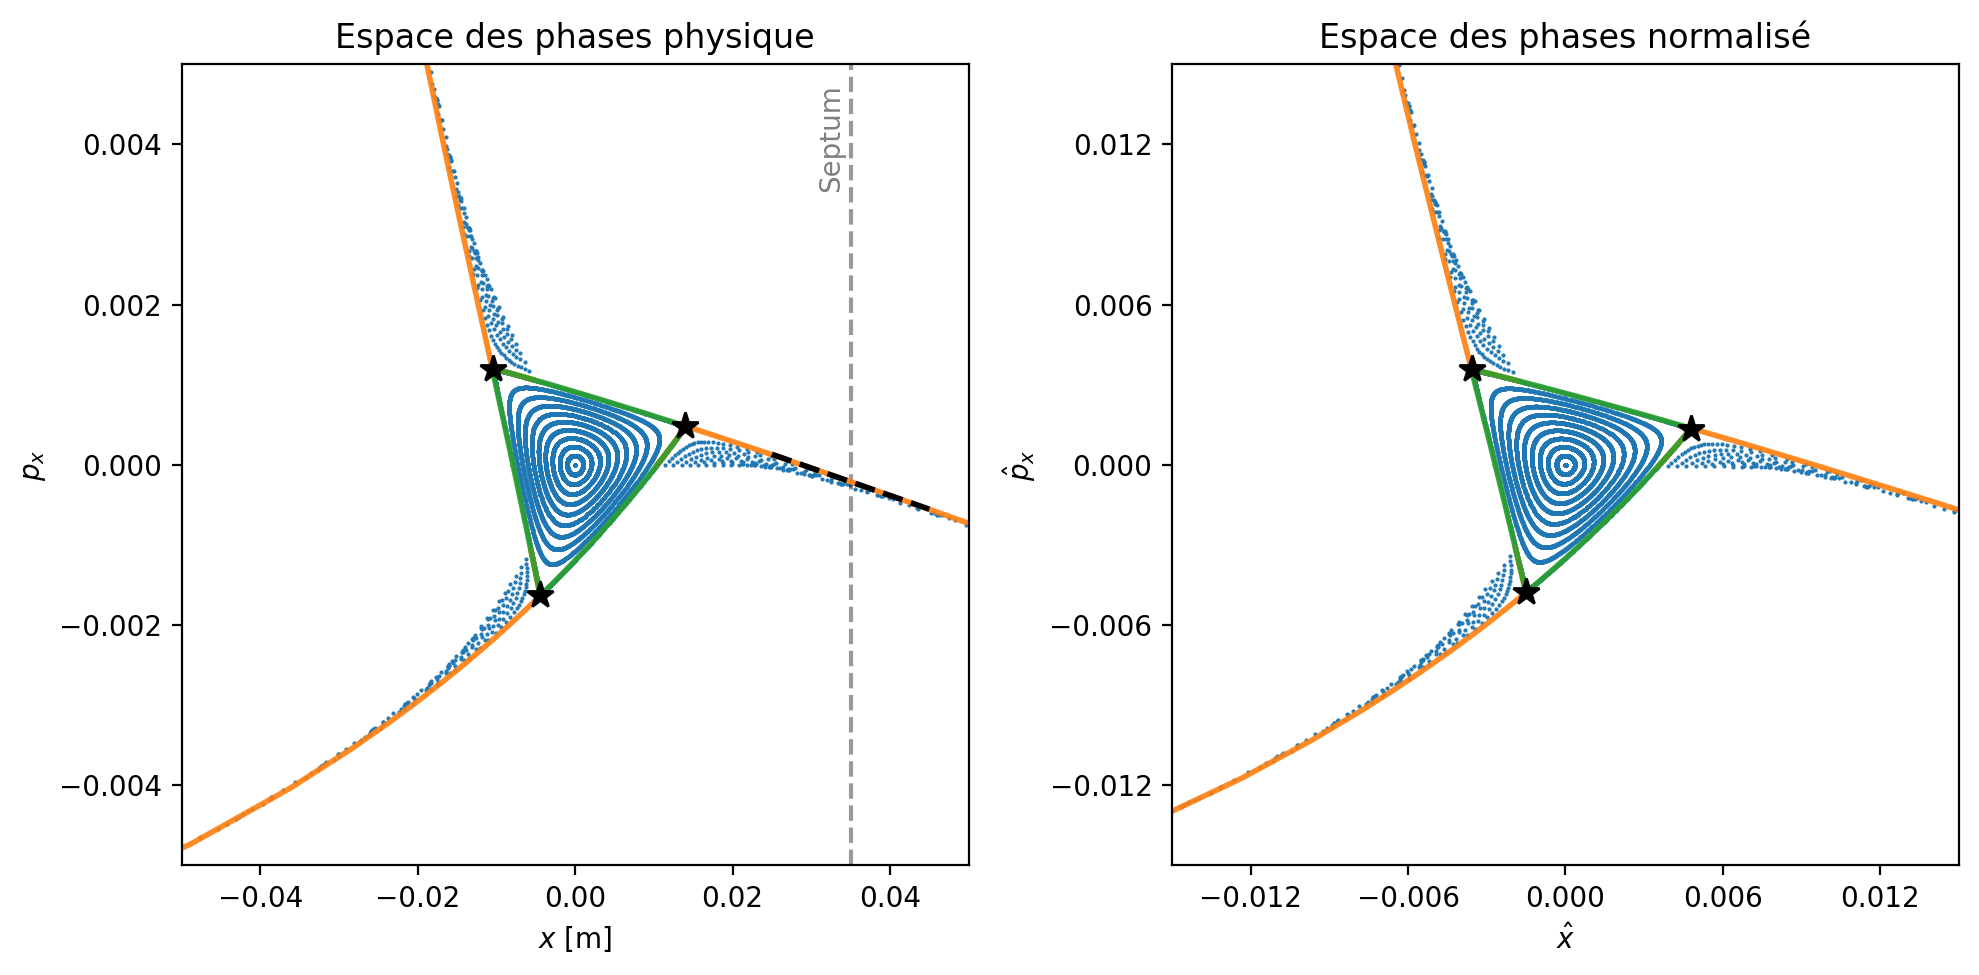

In [21]:
# On peut rajouter les points fixes à la topologie de l'espace des phases
fig, ax_geom, ax_norm = arrange_phase_space_plot()
ymin, ymax = ax_geom.get_ylim()
ax_geom.plot(record.x.T, record.px.T, ".", markersize=1, color="C0")
ax_norm.plot(norm_coords.x_norm.T, norm_coords.px_norm.T, ".", markersize=1, color="C0")
ax_geom.axvline(x=x_septum, color="k", alpha=0.4, linestyle="--")
ax_geom.text(x_septum * 0.98, ymax * 0.95, "Septum", rotation=90, va="top", ha="right", alpha=0.5, c="k")

# Rajout de la séparatrice identifiée
mask_alive = rec_separatrice.state > 0
for ii in range(3):
    ax_geom.plot(
        rec_separatrice.x[mask_alive][ii::3],
        rec_separatrice.px[mask_alive][ii::3],
        "-",
        lw=2,
        color="C1",
        alpha=0.9,
    )
    ax_norm.plot(
        norm_separatrice.x_norm[mask_alive][ii::3],
        norm_separatrice.px_norm[mask_alive][ii::3],
        "-",
        lw=2,
        color="C1",
        alpha=0.9,
    )

# Rajout de la pente de la séparatrice au septum
intervale_x_pente = [x_septum - 1e-2, x_septum + 1e-2]
ax_geom.plot(intervale_x_pente, np.polyval(poly_sep, intervale_x_pente), "--k", linewidth=2)

# Rajout des limites de la zone stable
ax_geom.plot(x_triangle, px_triangle, "-", lw=2, color="C2", alpha=0.9)
ax_norm.plot(x_norm_triangle, px_norm_triangle, "-", lw=2, color="C2", alpha=0.9)

# Rajout des points fixes
ax_geom.plot(x_fp, px_fp, "*", markersize=10, color="k")
ax_norm.plot(x_norm_fp, px_norm_fp, "*", markersize=10, color="k")

plt.tight_layout()

## Calcul de l'aire de la région stable

In [22]:
# L'aire correspond au déterminant de la matrice des sommets
# (le résultat est identique peu importe les coordonnées utilisées)
stable_area = np.linalg.det([x_norm_fp, px_norm_fp, [1, 1, 1]])

In [23]:
# Quelques résumés
print(f"Pente de la séparatrice au septum : {dpx_dx_at_septum=:f}")
print()
print("Coordonnées physiques des points fixes :")
print(f"    x :  {x_fp}")
print(f"    px : {px_fp}")
print()
print("Coordonnées normalisées des points fixes :")
print(f"    x_norm :  {x_norm_fp}")
print(f"    px_norm : {px_norm_fp}")
print()
print(f"Aire de la région stable : {stable_area}")

Pente de la séparatrice au septum : dpx_dx_at_septum=-0.034284

Coordonnées physiques des points fixes :
    x :  [-0.01049033 -0.00440707  0.01401406]
    px : [ 0.00120107 -0.00162625  0.00047853]

Coordonnées normalisées des points fixes :
    x_norm :  [-0.00357046 -0.00149996  0.00476989]
    px_norm : [ 0.0035696  -0.00475893  0.00135925]

Aire de la région stable : 6.488631516421928e-05


---